### Complex Networks
### Programming Assignment 1
### Jason Thomas
### s3907634

---


In [1]:
packages = c('testit', 'network', 'sna', 'scales')
for(package in packages) {
    library(package, character.only = TRUE)
}


‘network’ 1.18.1 (2023-01-24), part of the Statnet Project
* ‘news(package="network")’ for changes since last version
* ‘citation("network")’ for citation information
* ‘https://statnet.org’ for help, support, and other information


Loading required package: statnet.common


Attaching package: ‘statnet.common’


The following objects are masked from ‘package:base’:

    attr, order


sna: Tools for Social Network Analysis
Version 2.7-1 created on 2023-01-24.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
 For citation information, type citation("sna").
 Type help(package="sna") to get started.




In [2]:
source("assignment1_functions.R");

In [30]:
getAdjMatrix = function(filePath) {
    adjTable = read.table(file = filePath, header = FALSE);
    adjMatrix = as.matrix(adjTable);
    rownames(adjMatrix) <- colnames(adjMatrix); # so that we can check symmetry
    (adjMatrix);
}

# I tried for a while to display network graphs on a grid. It was easier to save 
# them to files and then combine them using a bash script.
# See the bash scipt makeGrid.sh
plotAllNetworksTogether = function(networks) {
    networkVizFolder = "networkViz";
    for (i in 1:length(networks)) {
        fileName = sprintf("chart%s.png", i);
        filePath = sprintf("%s/%s",networkVizFolder, fileName);
        title = sprintf("gvole net %s", i);
        png(filePath);
        plot(networks[[i]], main=title);
        dev.off();
    }
}

collectIndices = function(uncollectedIndices, searchResult) {
    componentIndices = c();
    otherIndices = c();
    for (i in uncollectedIndices) {
        if (searchResult[[i]] == -1) {
            otherIndices = c(otherIndices, i);
        } else {
            componentIndices = c(componentIndices, i);
        }
    }
    (list(component=componentIndices, other=otherIndices));
}

# This seemed simpler, in the end, compared to using igraph. Various reasons
partitionIndicesByComponent = function(network) {
    components = list();
    comp_i = 1;
    
    i = 1;
    searchResult = levels(network, i);
    nodeIndices = 1:length(searchResult); # These are assigned once and not again
    
    indices = collectIndices(nodeIndices, searchResult);
    componentIndices = indices$component;
    components[[comp_i]] = componentIndices;
    uncollectedIndices = indices$other;
    
    while (length(uncollectedIndices) > 0) {
        i = uncollectedIndices[1];
        searchResult = levels(network, i);
        
        indices = collectIndices(uncollectedIndices, searchResult);
        componentIndices = indices$component;
        
        comp_i = comp_i + 1;
        components[[comp_i]] = componentIndices;
        uncollectedIndices = indices$other;
    }
    (components)
}

getLargestComponentIndices = function(components) {
    largest_i = 1;
    largestNumberOfPaths = 0;
    for (i in 1:length(components)) {
        component = components[[i]];
        if (length(component) > largestNumberOfPaths) {
            largestNumberOfPaths = length(component);
            largest_i = i;
        }
    }
    (components[[largest_i]])
}

chompMinus1 = function(vector) {
    chompedVector = c();
    for (i in 1:length(vector)) {
        if (vector[[i]] != -1) {
            chompedVector = c(chompedVector, vector[[i]]);
        }
    }
    (chompedVector)
}

getLargestComponentPathMatrix = function(largestComponentIndices, network, n) {
    numberOfIndices = length(largestComponentIndices);
    pathMatrix = matrix(, nrow=numberOfIndices, ncol=0);
    for (i in largestComponentIndices) {
        pathLengths = levels(network, i);
        pathLengths = chompMinus1(pathLengths);
        pathMatrix = cbind(pathMatrix, pathLengths);
    }
    (pathMatrix)
}

getDataForNetwork = function(network, dataForAllNetworks) {
    n = network.size(network);
    e = network.edgecount(network);
    indicesByComponent = partitionIndicesByComponent(network);
    numberOfComponents = length(indicesByComponent);
    largestComponentIndices = getLargestComponentIndices(indicesByComponent);
    largestComponentPathMatrix = getLargestComponentPathMatrix(largestComponentIndices, network, n);
    numberOfNodesInLargestComponent = length(largestComponentIndices);
    fractionOfNodesInLargestComponent = numberOfNodesInLargestComponent/n;
    averageDegree = mean(degree(network, gmode="graph"));
    averagePathLengthForLargestComponent = mean(largestComponentPathMatrix);
    
    dataForNetwork = list(net_id=get.network.attribute(network, "net id"),
                          node_count=n,
                          edge_count=e,
                          component_count=numberOfComponents,
                          largest_component_node_share=fractionOfNodesInLargestComponent,
                          average_degree=averageDegree, 
                          average_path_length_longest_component=averagePathLengthForLargestComponent );
    
    (dataForNetwork)
}

getDataForAllNetworks = function(networks) {
    dataForAllNetworks = data.frame(net_id = integer(),
                                    node_count = integer(),
                                    edge_count = integer(),
                                    comonent_count = integer(),
                                    largest_component_node_share = integer(),
                                    average_degree = numeric(),
                                    average_path_length_longest_component = numeric()
                                   );

    for (i in 1:length(networks)) {
        dataForOneNetwork = getDataForNetwork(networks[[i]]);
        dataForAllNetworks = rbind(dataForOneNetwork,dataForAllNetworks);
    }
    (dataForAllNetworks[order(dataForAllNetworks$net_id),])
}


In [31]:
matricesFolder = "adj_matrices";

if (file.exists(matricesFolder)){
    fileNames = list.files(matricesFolder);
} else {
    stop("Matrix directory not found");
}

networks = c();

for (i in 1:length(fileNames)) {
    fileName = fileNames[i];
    filePath = sprintf("%s/%s",matricesFolder, fileName);
    
    adjMatrix = getAdjMatrix(filePath);

    network <- as.network.matrix(adjMatrix, matrix.type="adjacency", directed=FALSE);
    
    set.network.attribute(network,"net id", i);
    
    networks[[i]] = network;
}


### Question 1

In [32]:
plotAllNetworksTogether(networks);

In [33]:
data = getDataForAllNetworks(networks);
data

,net_id,node_count,edge_count,component_count,largest_component_node_share,average_degree,average_path_length_longest_component
,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
32,1,29,33,7,0.6551724,2.2758621,3.229917
31,2,125,251,8,0.5920000,4.0160000,5.783419
30,3,164,657,2,0.9878049,8.0121951,3.654169
29,4,242,1083,1,1.0000000,8.9504132,3.823475
28,5,219,630,4,0.9634703,5.7534247,5.492644
27,6,232,612,11,0.4568966,5.2758621,4.255429
26,7,141,293,8,0.8865248,4.1560284,8.420352
25,8,49,122,1,1.0000000,4.9795918,3.707622
24,9,28,37,6,0.3571429,2.6428571,1.580000


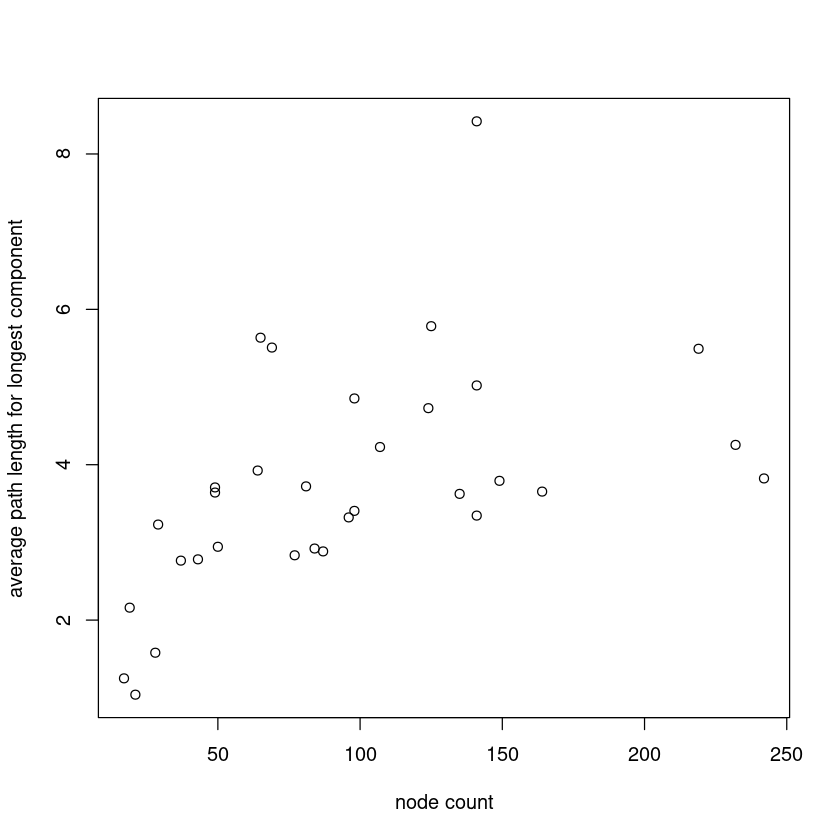

In [41]:
plot(data$node_count,
     data$average_path_length_longest_component,
     xlab="node count",
     ylab="average path length for longest component");

We might also like to see the Pearson Correlation Coefficient and the level of confidence that we can have, given a default confidence level of $0.95$.

In [52]:
result = cor.test(data$node_count, data$average_path_length_longest_component);
print("Coefficient:")
result$estimate
print("p-value:")
result$p.value

[1] "Coefficient:"


cor 
0.5104153

[1] "p-value:"


[1] 0.002838382

Given the confidence level of $0.95$, then we apply $ \alpha = 0.05 $. Since the p-value is lower than the $ \alpha $ then this result is statistically significant.

Note that this interpretation relies on their being a good sample without sampling errors.

Regarding the networks in this analysis: each edge represents a direct contact between one vole and another. If two voles are connected by a path that has more than one edge then those two voles have no direct contact.

The plot above suggests there is a strong correlation between the data. The Pearson Correlation Coefficient suggests the same result.

This correlation suggests that these animals are either territorial or limit their contact with others of their species for some other survival reason.

In [36]:
### Test collectIndices

nodeIndices = 1:7
searchResult = c(-1,2,1,2,-1,-1,1)

result = collectIndices(nodeIndices, searchResult)

assert(as.vector(result$other) == c(1,5,6))
assert(as.vector(result$component) == c(2,3,4,7))

In [18]:
### Test partitionIndicesByComponent sparse network

adjMatrix = matrix(c(0,1,0,0,0,0,1,
                     1,0,0,0,0,0,0,
                     0,0,0,1,0,0,0,
                     0,0,1,0,1,0,0,
                     0,0,0,1,0,0,0,
                     0,0,0,0,0,0,0,
                     1,0,0,0,0,0,0), 
                   nrow=7,
                   ncol=7)

network <- as.network.matrix(adjMatrix, matrix.type="adjacency", directed=FALSE)

result = partitionIndicesByComponent(network)

assert(result[[1]] == c(1,2,7))
assert(result[[2]] == c(3,4,5))
assert(result[[3]] == c(6))

In [19]:
### Test getLargestComponentPathLengths

components = list()
components[[1]] = c(5,4,3,2,1)
components[[2]] = c(1)
components[[3]] = c(3,2,1)

result = getLargestComponentIndices(components)

assert(result == c(5,4,3,2,1))

In [37]:
### Test chompMinus1

vector = c(-1,-1,1,0,2,-1,1,3)

result = chompMinus1(vector);
assert(result == c(1,0,2,1,3));

In [38]:
### Test getLargestComponentPathMatrix 

adjMatrix = matrix(c(0,1,0,0,0,0,1,
                     1,0,0,0,0,0,0,
                     0,0,0,1,1,0,0,
                     0,0,1,0,1,0,0,
                     0,0,1,1,0,0,0,
                     0,0,0,0,0,0,0,
                     1,0,0,0,0,0,0), 
                   nrow=7,
                   ncol=7)

network <- as.network.matrix(adjMatrix, matrix.type="adjacency", directed=FALSE);

largestComponentIndices = c(3,4,5)

result = getLargestComponentPathMatrix(largestComponentIndices, network, 7)

expected = matrix(c(0,1,1,
                    1,0,1,
                    1,1,0), 
                   nrow=3,
                   ncol=3);

assert(result == expected);